## Quantum Hadamard edge detector

In this notebook we provide an implementation of the Quantum Hadamard Edge Detection (QHED) algorithm [1], for 2 images and 3D volumes.  We provide an implementation on Qiskit, following the tutorial [2], which is meant to run on real hardware or fake simulators. We also provide an implementation with pytorch, which is optimized to work faster in quantum simulation (CPUs and GPUs).


[1]  Yao, Xi-Wei, et al. "Quantum image processing and its application to edge detection: theory and experiment." Physical Review X 7.3 (2017): 031041.

[2] Quantum Edge Detection - QHED Algorithm on Small and Large Images https://qiskit.org/textbook/ch-applications/quantum-edge-detection.html#Quantum-Hadamard-Edge-Detection-(QHED)

In [1]:
import random
import numpy as np
from data.data_reader import Dataset_MLHDF
from data.img_util import GaussianFilter, Voxelizer3D
import torch
import torch.nn as nn
import math

from torch.nn.parallel import DataParallel, DistributedDataParallel
from torch.optim import Adam, RMSprop, lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
from quantum_edge_detection2D import *
from quantum_edge_detection3D import *

In [2]:
import qiskit 
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.quantum_info import Statevector
import itertools
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.quantum_info.states.utils import partial_trace
from qiskit.quantum_info import DensityMatrix

## 2D example

We first provide the code to run a 2D image with Qiskit. This code is meant to be run in a real quantum computer or a fake provider. We use the same images as in the tutorial [2]. Since the image is quite large ($256 \times 256$), we can not process the whole image with the current hardware (or quantum simulation). For this reason, we split the image into ($4\times 4$) blocks, and apply the edge algorithm to each block. Let's start by visualizing the image.

Raw Image info: (366, 366, 4)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


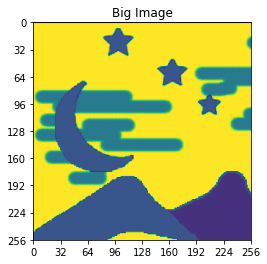

In [3]:
from PIL import Image

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('images/edge-detection.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

### Run with Qiskit code

In [4]:
# You could try running it with a fake backend. It takes a lot of time...
#from qiskit.providers.fake_provider import FakeMelbourne
#backend =  FakeMelbourne()
edge_detector = EdgeDetector2D(size=4, shots=2**10)#, backend = backend)
reverted_image = edge_detector.run(np.array(image).reshape(1,256,256), tol=1e-5, reduce=False, verbose=1).reshape(256,256)

100%|██████████| 4096/4096 [01:37<00:00, 42.20it/s]


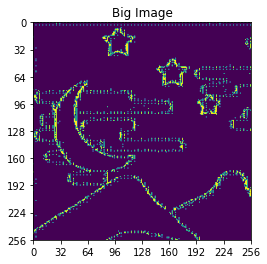

In [5]:
# Display the image
plt.title('Big Image')
plt.xticks(range(0, reverted_image.shape[0]+1, 32))
plt.yticks(range(0, reverted_image.shape[1]+1, 32))
plt.imshow(reverted_image, extent=[0, reverted_image.shape[0], reverted_image.shape[1], 0], cmap='viridis')
plt.show()

## Run with pytorch

In [13]:
edge_detector = EdgeDetector2D(size=4, backend='torch')
reverted_image = edge_detector.run(torch.tensor(image).reshape(1,256,256), tol=1e-2, reduce=False, verbose=1).reshape(256,256)

Total execution time:  0.003176450729370117


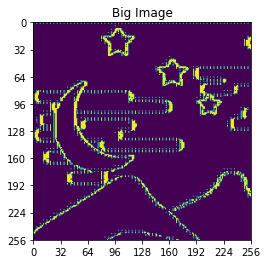

In [14]:
# Display the image
plt.title('Big Image')
plt.xticks(range(0, reverted_image.shape[0]+1, 32))
plt.yticks(range(0, reverted_image.shape[1]+1, 32))
plt.imshow(reverted_image, extent=[0, reverted_image.shape[0], reverted_image.shape[1], 0], cmap='viridis')
plt.show()

The edge detection algorithm works! Notice that running the algorithm with the pytorch backend is much faster than running it with quantum simulation in the Qiskit backend. Also, the results using the qiskit backend depend on the number of shots of the experimet, that should be large enough to produce good results. 

Another parameter of the algorithm is the tolerance *tol*. It measures how big does the gradient need to be so that it is considered an edge. This value should be tuned for different datasets, so it should be set by the user.

## Application to 3D data

Now we show an example of a 3D volume, processed from the PDBBind dataset for protein-ligand prediction.

## Load the data

We begin by loading some samples of the data and visualizing them

In [ ]:
dataset = Dataset_MLHDF('data/pdbbind2016_core_test.hdf', 1, 'data/core_test_3dnn.csv', is_crystal=True, rmsd_weight=0, rmsd_thres=20)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, worker_init_fn=None)
voxelizer = Voxelizer3D(use_cuda=False, verbose=1)
gaussian_filter = GaussianFilter(dim=3, channels=19, kernel_size=11, sigma=1, use_cuda=False)

/home/jovyan/python_packages/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
device = torch.device("cpu")
vol_batch = torch.zeros((1,19,48,48,48)).float().to(device)
for batch_ind, batch in enumerate(dataloader):
    x_batch, y_batch = batch
       # voxelize into 3d volume
    for i in range(x_batch.shape[0]):
        xyz, feat = x_batch[i,:,:3], x_batch[i,:,3:]
        vol_batch[i,:,:,:,:] = voxelizer(xyz, feat)
    vol_batch_gaus = gaussian_filter(vol_batch)
    break

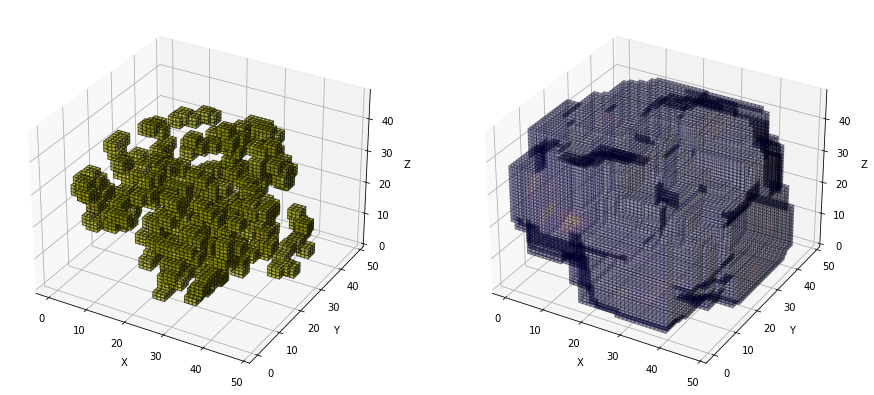

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

d2 = vol_batch_gaus[0][1].numpy()
d = vol_batch[0][1].numpy()

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax1.voxels(d,facecolors='yellow', alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.2,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

## Run with pytorch backend

In [6]:
edge_detector = EdgeDetector3D(size=16, backend='torch')

In [7]:
data = vol_batch_gaus
data_processed = edge_detector.run(data, num_filters=1, tol=3e-3, reduce=False, verbose=1)

/home/jovyan/FASTQML/python_package/quantum_edge_detection3D.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_larger = torch.kron(torch.tensor(normalized_flatten),torch.tensor([1,0]).to(self.device))


Total execution time:  0.49309277534484863


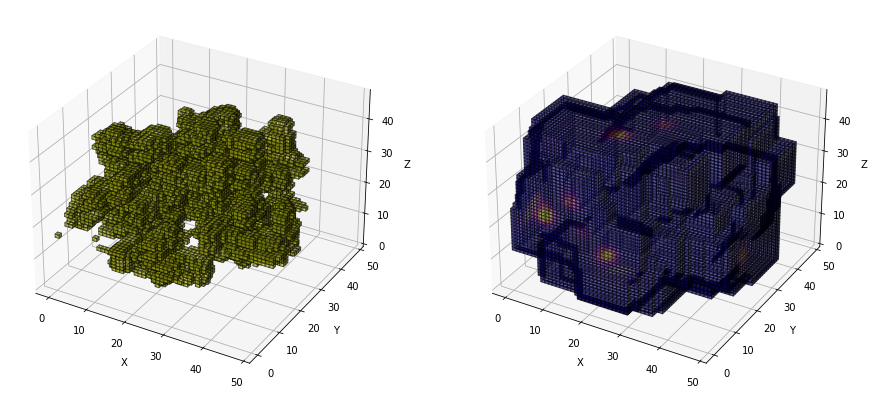

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

d2 = data[0,10].numpy()
d = data_processed[0,10].numpy()

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d,facecolors=colors, alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.4,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

## Run with Qiskit backend

Now we run the code with Qiskit backend in quantum simulation. We see that the execution time is much longer than running the algorithm with pytorch. 

In [18]:
edge_detector = EdgeDetector3D(size=4, shots=2**10)

In [19]:
data = vol_batch_gaus
data_processed = edge_detector.run(data.numpy().copy(), num_filters=3, tol=3e-3, reduce=False, verbose=1)

100%|██████████| 32832/32832 [16:30<00:00, 33.15it/s]  


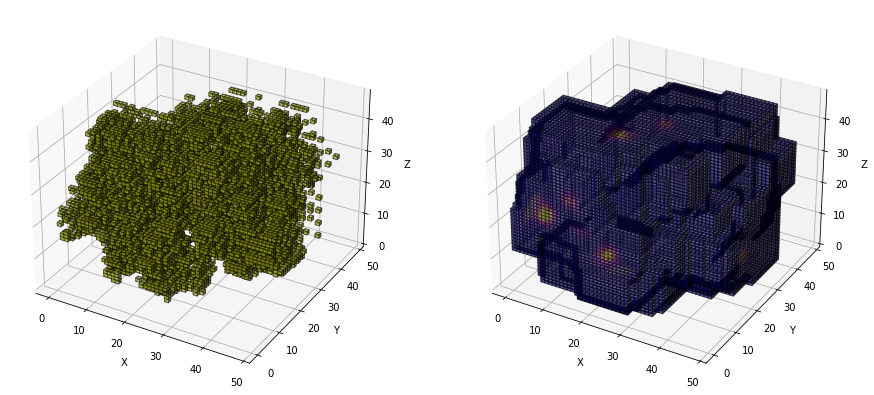

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors

d2 = data[0,10].numpy()
d = data_processed[0,10]

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
colors = plt.cm.plasma(d)
ax1.voxels(d,facecolors=colors, alpha = 0.4,edgecolor='k')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

colors = plt.cm.plasma(d2)
ax2.voxels(d2,facecolors=colors,alpha = 0.4,edgecolor='k')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

In [151]:
import random
import numpy as np

import qiskit 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit import BasicAer
from qiskit import transpile, assemble
from qiskit.quantum_info import Statevector
import itertools
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pickle

class QuantumFilters2D():
    
    description = "Applies a quantum filter to a 3D volume.  Quantum data encoding: Flexible Representation of Quantum Images. Quantum transformation: quantum reservoirs with fixed number of gates. Implemented: G1 = {CNOT, H, X}, G2 = {CNOT, H, S}, and G3={CNOT,H,T} and evolution under the transverse field Ising model. The code is designed to run either in a Qiskit backend or with Pytorch."
    class_parameters = {
        "shape": "(n,n), n integer. Box size in which the data is split to apply the quantum filter. The hilbert space is better exploit if we set n^2=2^l.",
        "stride": "int. Stride used to move across the image.",
        "nqbits": "Number of qubits of the quantum circuits. nqbits = [log2(n^2)] + 1. This parameter can not be chosen by the user.",
        "num_filters": "Number of quantum features applied to each of the features of the data. If the input data has shape (n_samples,num_features,N,N), the output data has shape (n_samples, num_features*num_filters,N,N,N)",
        "num_samples": "Number of samples of the input data",
        "device": "Pytorch device (cpu, cuda). Only used if the backend is torch",
        "num_gates": "Number of quantum gates of the quantum reservoir",
        "gates_set": "List of quantum gates that form the quantum reservoir",
        "qubits_set":"List of qubits to which the quantum gates are applied to",
        "U_list_filters": "list of all the quantum unitaries that define the quantum reservoirs. The list has shape (num_filters, num_features, nqbits, nqbits). Only used if backend is torch.",
        "shape_windows": "shape of the sliding windows",
        "shots": "Number of shots per experiment (only Qiskit backends)",
        "backend": "Backend where to run the code. Either Qiskit bachend or torch"
            }
    required_parameters = {}
    optional_parameters = {
        "shape": "(n,n), n integer. Box size in which the data is split to apply the quantum filter. The hilbert space is better exploit if we set n^2=2^l.",  
        "stride": "int. Stride used to move across the image.",
        "shots": "Number of shots per experiment (only Qiskit backends)",
        "backend": "Backend where to run the code. Either Qiskit bachend or torch"
    }
    example_parameters = {
        "shape": "(2,2,2)",
        "stride": "2",
        "shots":"4096",
        "backend":"aer_simulator"
    }
    
    def __init__(self, shape: tuple=(4,4), stride:float=1, shots=4096,backend ='torch'):
        self.shape = shape
        self.nqbits = int(np.ceil(np.log2(self.shape[0]**2)) + 1) # Calculate the number of qubits
        self.stride=stride
        self.num_filters = 1
        self.shots=shots
        self.backend = backend
        if self.backend=='torch':
            # set CUDA for PyTorch
            use_cuda = torch.cuda.is_available()
            if use_cuda:
                self.device = torch.device("cuda:0")
                torch.cuda.set_device(int("cuda:0".split(':')[1]))
            else:
                self.device = torch.device("cpu")
            
          
    def _FRQI_encoding(self, box):
        '''
        Flexible representation of Quantum Images encoding. Takes an (nxnxn) box and returns the encoded quantum circuit. 
        This function is only used with Qiskit backends.
            box (np.array): (nxnxn) box to be encoded
        '''
        # check if the box has the correct shape
        assert box.shape==self.shape

        # Calculate binary string of basis qubits
        qbit_list = list(itertools.product([0, 1], repeat=self.nqbits-1))
        coefs = {}
        l=0
        for i in range(box.shape[0]):
                for j in range(box.shape[1]):
                        theta = box[i,j]
                        q_str = [str(q) for q in qbit_list[l]]
                        q_str = ''.join(q_str)
                        coefs[q_str + '0'] = np.cos(theta)/np.sqrt(self.shape[0]**2)
                        coefs[q_str + '1'] = np.sin(theta)/np.sqrt(self.shape[0]**2)
                        l+=1
        # store them in a dictionary and sort it by keys
        coefs = list(collections.OrderedDict(sorted(coefs.items())).values())

        # Define quantum circuit
        cr = ClassicalRegister(self.nqbits-1)
        qr = QuantumRegister(self.nqbits)
        qc = QuantumCircuit(qr,cr)

        # Calculate initial state
        initial_state = np.zeros(2**self.nqbits)
        coefs =  coefs/np.sqrt(np.sum(np.square(coefs)))
        initial_state[:coefs.shape[0]] = coefs
        qc.initialize(initial_state, list(range(self.nqbits)))
        return qc,  initial_state    
    
    
    def _apply_G_gates(self, qc, measure=False):
        """Selects a set of random qubits and random gates from the G1, G2 or G3 family, ans stores them in a list.
        These gates form the random quantum circuit.
            qc (QuantumCircuit): quantum circuit
            measure (bool): mneasure all the qubits (except the ancilla) at the end of the circuit
        """
        # Apply random gates to random qubits
        for i in range(len(self.gates_set)):
            # Select random gate
            gate = self.gates_set[i]
            if gate=='CNOT': # For 2-qubit gates
                # Select qubit 1 and 2 (different qubits)
                qbit1, qbit2 = self.qubits_set[i]
                # Apply gate to qubits
                qc.cx(qbit1, qbit2) 
            else: # For 1-qubit gates
                # Select qubit
                qbit = self.qubits_set[i][0]
                if gate=='X':# Apply gate
                    qc.x(qbit) 
                elif gate=='S':# Apply gate
                    qc.s(qbit) 
                elif gate=='H':# Apply gate
                    qc.h(qbit) 
                elif gate=='T':# Apply gate
                    qc.t(qbit) 
                else:
                    raise ValueError("Unknown quantum gate:", gate)
        if measure:
            qc.measure(list(range(self.nqbits-1)), list(range(self.nqbits-1)))
    
    def _apply_gates_ising(self, t: float=10):
        """Applies quantum evolution under the transverse field Ising model. The parameters of the Ising model are chosen according to R. Martínez-Peña et al. (2021). 
        Js ~ N(0.75, 0.1), Jij ~ U(-Js/2, Js/2) and hi = h such that h/Js = 0.1. 
            t (float): time evolution
        returns:
            (QuantumCircuit): quantum circuit representing the evolution of the Ising model"""
        # Define parameters Ising model
        Js = np.random.normal(0.75, 0.1)
        h_over_Js = 0.1
        h = Js*h_over_Js
        
        # Get list of all qubits and pairs of qubits
        qubit_idx = list(range(self.nqbits))
        qubit_pairs = list(itertools.combinations(qubit_idx, 2))
        
        # Define the Ising model operators
        pauli_op = 0
        name_gate=''
        for i in range(self.nqbits):
            name_gate+= 'I' 
        for pair in qubit_pairs: # Interaction operators
            name = name_gate[:pair[0]] + 'Z' + name_gate[(pair[0]+1):pair[1]] + 'Z' + name_gate[(pair[1]+1):]
            coef = np.random.uniform(-Js/2,Js/2)
            pauli_op += coef*PauliOp(Pauli(name))

        for qubit in qubit_idx:# Single qubit operators
            name = name_gate[:qubit] + 'X' + name_gate[(qubit+1):]
            coef = h
            pauli_op += coef*PauliOp(Pauli(name))
        
        # Time evolution operator exp(iHt)
        evo_time = Parameter('θ')
        evolution_op = (evo_time*pauli_op).exp_i()
        # Trotterization 
        trotterized_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(evolution_op)
        bound = trotterized_op.bind_parameters({evo_time: t})
        # Convert the trotterized operator to a quantum circuit
        qc_ham = bound.to_circuit()
        return qc_ham
    
    def _rollNumpy(self, a,      
             b,     
             dx=1,    
             dy=1):   
        '''
        Rolling 3D window for numpy array. This function is only used with Qiskit backends.
            a (np.array): input array
            b (np.array): rolling 2D window array
            dx (int): horizontal step, abscissa, number of columns
            dy (int): vertical step, ordinate, number of rows
        '''
        shape = a.shape[:-2] + \
                ((a.shape[-2] - b.shape[-2]) // dy + 1,) + \
                ((a.shape[-1] - b.shape[-1]) // dx + 1,) + \
                b.shape  # multidimensional "sausage" with 3D cross-section
        strides = a.strides[:-2] + \
                  (a.strides[-2] * dy,) + \
                  (a.strides[-1] * dx,) + \
                  a.strides[-2:]
        self.shape_windows = shape
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    
    def _roll(self, a,      
             b,     
             dx=1,   
             dy=1):  
        '''
        Rolling 3D window for pytorch tensor. This function is only used with Pytorch backends.
            a (tensor): input array, shape (n_samples, N,N,N)
            b (tensor): rolling 3D window array, shape (n,n,n)
            dx (int): horizontal step, abscissa, number of columns
            dy (int): vertical step, ordinate, number of rows
        '''
        shape = a.shape[:-2] + \
                ((a.shape[-2] - b.shape[-2]) // dy + 1,) + \
                ((a.shape[-1] - b.shape[-1]) // dx + 1,) + \
                b.shape  # multidimensional "sausage" with 3D cross-section
        strides = a.stride()[:-2] + \
                (a.stride()[-2] * dy,) + \
                (a.stride()[-1] * dx,) + \
                  a.stride()[-2:]

        self.shape_windows = shape
        return torch.as_strided(a, shape, strides)
    
    def _scale_data(self, data):
        """
        Scale the data to [0, pi/2) (each feature is scaled separately)
            data (tensor): input data, shape (n_samples, num_features, N,N,N)
        returns:
            (tensor): scaled data, shape (n_samples, num_features, N,N,N)
        """
        size = data.shape[0]
        for i in range(data.shape[0]):# Scale each feature independently
            for j in range(data.shape[1]):
                v_min, v_max = data[i,j,:,:].min(), data[i,j,:,:].max()
                new_min, new_max = 0, np.pi/2
                if v_min<v_max:
                    data[i,j,:,:] = (data[i,j,:,:] - v_min)/(v_max - v_min)*(new_max - new_min) + new_min                    
        return data
    
    def _select_gates_qubits(self):
        """
            Selects random gates from the G1, G2 and G3 family, and the qubits to which the gates are applied to.
        """
        self.gates_set = []
        self.qubits_set = []
        # Store gate names
        if self.gates_name=='G1':
            gates = ['CNOT', 'H', 'X']
        if self.gates_name=='G2':
            gates = ['CNOT', 'H', 'S']
        if self.gates_name=='G3':
            gates = ['CNOT', 'H', 'T']  
        
        #Store qubit list of applied gates
        qubit_idx = list(range(self.nqbits))
        for i in range(self.num_gates):
            # Select random gate
            gate = random.sample(gates,1)[0] 
            self.gates_set.append(gate)
            if gate=='CNOT':
                # Select qubit 1 and 2 (different qubits)
                qbit1 = random.sample(qubit_idx,1)[0]
                qubit_idx2 = qubit_idx.copy()
                qubit_idx2.remove(qbit1)
                qbit2 = random.sample(qubit_idx2,1)[0]
                self.qubits_set.append([qbit1, qbit2])
            else:
                # Select qubit
                qbit = random.sample(qubit_idx,1)[0]
                self.qubits_set.append([qbit])
                      
    def _run_boxQiskit(self, box, gates_set, qubits_set):
        '''
        For a given box of the image runs the FRQI encoding + random quantum circuit.  This function is only used with Qiskit backends.
            box (np.array): shape (n,n). Input data
            gates_set (list): Set of random quantum gates
            qubits_set (list): List of qubits to apply the quantum gates
        '''
        # FRQI encoding
        qc, initial_state = self._FRQI_encoding(box)
        
        # Random quantum circuit
        self.gates_set = gates_set
        self.qubits_set = qubits_set
        if self.gates_name=='Ising':
            qc_Ising = self._apply_gates_ising()
            qc+=qc_Ising
        else:
            self._apply_G_gates(qc, measure=True)
        
        # Get counts
        if self.backend=='aer_simulator':
            aer_sim = Aer.get_backend(self.backend)
            t_qc = transpile(qc, aer_sim)
            qobj = assemble(t_qc, shots=self.shots)
            result = aer_sim.run(qobj).result()
        else: # For real hardware/fake simulators
            coupling_map = self.backend.configuration().coupling_map
            optimized_3 = transpile(qc, backend=self.backend, seed_transpiler=11)
            result = self.backend.run(optimized_3, shots=self.shots).result()
        counts = result.get_counts(qc)
        
        # Calculate binary string of basis qubits
        qbit_list = list(itertools.product([0, 1], repeat=self.nqbits-1))
        new_counts = []
        for l in range(len(qbit_list)):
            q_str =''.join([str(value) for value in qbit_list[l]])
            new_counts.append(counts.get(q_str, 0))

        new_counts/=np.sum(new_counts)
        return new_counts
    
    def _run_filterQiskit(self, data,  gates_set, qubits_set, tol=1e-6):
        '''
        Runs the quantum circuit for one feature of the data.  This function is only used with Qiskit backends.
            data (np.array): shape (N,N), channel of the image 
            gates_set (list): Set of random quantum gates
            qubits_set (list): List of qubits to apply the quantum gates
            scale (bool): Scale the input image
        '''
        # Get boxes from data
        size = self.shape[0]
        b=np.zeros(self.shape)
        windows = self._rollNumpy(data,b,dx=size*self.stride,dy=size*self.stride).reshape(-1,size,size)       
        
        results = []
        for i in range(windows.shape[0]): # Loop through every box of the image
            # If all values are zero, no need to run the algo
            box = windows[i]
            if np.sum(np.abs(box))>tol: # Run the QC if the box is non-zero valued
                result = np.array(self._run_boxQiskit(box,  gates_set, qubits_set))
                result = result[:self.shape[0]**2].reshape(self.shape)
            else: # Return zeros if the box is all zero-valued
                result = np.array([0 for i in range(self.shape[0]**2)]).reshape(self.shape)
            results.append(result)
        
        # Reshape the results in the original shape
        results = np.array(results).reshape(self.shape_windows) # Reshape results to rolling windows shape
        fin_shape = int(data.shape[-1]/self.stride)
        results = results.transpose([0, 2, 1, 3]).reshape(fin_shape,fin_shape)# Transpose to obtain original shape
        
        # Apply zero-mask
        mask = np.ones(self.shape_windows) 
        windows_reshape = windows.reshape(self.shape_windows)# Reshape to rolling windows shape
        mask[np.abs(windows_reshape)<tol] = 0 #Find zero-valued values of the original data
        mask = mask.reshape(self.shape_windows).transpose([0, 2, 1, 3]).reshape((fin_shape,fin_shape))# Transpose to return to original shape
        results = results.astype('float64')
        results*=mask #Apply mask
        return results
    
    def _run_filter(self, data,tol, U):
        """
            Runs a quantum filter to a feature from the data samples.  This function is only used with Pytorch backend.
                data (tensor): input data (one feature), shape (num_samples, N,N,N)
                tol (float): tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0.
                U (tensor): Unitary matrix representing the random quantum circuit
            returns:
                (tensor): quantum filter applied to data
        """
        # 0. Get rolling windows
        size = self.shape[0]
        b=torch.zeros(self.shape)
        windows = self._roll(data,b,dx=size*self.stride,dy=size*self.stride).reshape(-1,size,size).to(self.device)


        # 1. Flexible representation of quantum images. Apply cos(theta)|0> + sin(theta)|1> transformation
        v1 = torch.tensor([1,0]).to(self.device)
        v2 = torch.tensor([0,1]).to(self.device)
        sq = torch.tensor([self.shape[0]**2]).to(self.device)

        frqi = (torch.kron(torch.cos(windows),  v1) +
           torch.kron(torch.sin(windows) , v2))/torch.sqrt(sq)

        # 2. Flatten the last dimension to create an initial state
        flatten = frqi.reshape(-1,2**(self.nqbits)).type(torch.complex128)
        # 3. Apply U rotation to each state
        apply_U = (U @ flatten.T).reshape(-1,size, size, 2)

        # 4. Partial trace to remove the extra qubit
        partial_trace = torch.einsum('ijkl->ijk', apply_U)

        # 5. Reshape back to window view
        partial_trace_reshaped = partial_trace.reshape(self.shape_windows)

        # 6. Reshape to original shape, taking into account transposition
        fin_shape = int(data.shape[-1]/self.stride)
        output = partial_trace_reshaped.permute([0, 1, 3, 2, 4]).reshape((self.num_samples, 
                                                                 fin_shape,fin_shape))

        # 7. Get the probability for each state (modulus of the final state)
        output_probability = (output.conj()*output).real

        # 8. Create a mask to map to zero all zero values of the original image
        mask = torch.ones(windows.shape)
        mask[np.abs(windows)<tol] = 0
        mask = mask.reshape(self.shape_windows).permute([0, 1, 3, 2, 4]).reshape((self.num_samples,
                                                                                      fin_shape,fin_shape)).to(self.device)
        quantum_filter = output_probability*mask        
        return quantum_filter
        
    
    def generate_unitaries(self, gates_name='G3',num_gates=300, num_filters=3, num_features = 19, name='U.pickle', save=True):
        """
        Generates the quantum unitaries that represent the quantum reservoirs (random quantum circuits).  This function is only used with Pytorch backend.
            gates_name (str): name of the family of quantum gates. Either G1, G2, G3 or Ising
            num_gates (int): depth of the quantum circuits
            num_filters (int): Number of quantum filters to apply to each feature
            num_features (int): Number of features of the data
            name (str): name of the file containing unitary list (only needed if save=True)
            save (bool): if True, the generated unitaries are saved to a pickle file.
        """
        if self.backend!='torch':
            raise ValueError("This function is only callable with the 'torch' backend")
        self.U_list_filters = []
        self.num_filters = num_filters
        self.gates_name = gates_name
        for i in range(num_filters):
            U_list = []
            for j in range(num_features):
                # Store circuit parameters
                self.gates_name = gates_name
                self.num_gates = num_gates
                # If the quantum reservoir is the Ising model
                if gates_name=='Ising':
                    qc = self._apply_gates_ising()
                else: # Otherwise, if it is one of the G families
                    self._select_gates_qubits()
                    # Get unitary
                    qc = QuantumCircuit(self.nqbits)
                    # Random quantum circuit
                    self._apply_G_gates(qc)
                # Get unitary
                backend = BasicAer.get_backend('unitary_simulator')
                job = backend.run(transpile(qc, backend))
                U = job.result().get_unitary(qc)
                U_list.append(U)
            self.U_list_filters.append(U_list)
        # Save unitaries to file
        if save:
            with open(name, 'wb') as f:
                pickle.dump(self.U_list_filters, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def generate_qc(self, gates_name='G3',num_gates=300, num_filters=3,num_features = 19, save=True,
                    name_gates='gates_list.pickle', name_qubits = 'qubits_list.pickle'):
        '''
        Generate sets of random quantum gates and their associated qubits and saves them. This function is only used with Qiskit backends.
            gates_name (str): name of the family of quantum gates. Either G1, G2, G3 or Ising
            num_gates (int): depth of the quantum circuits
            num_filters (int): Number of quantum filters to apply to each feature
            num_features (int): Number of features of the data
            save (bool): Save the gates and qubits to pickle files
            name_gates (str): File name for gates set
            name_qubits (str): File name for qubit set
        '''
        if self.backend=='torch':
            raise ValueError("This function is only callable with the Qiskit backends")
        self.gates_set_list = []
        self.qubits_set_list = [] 
        # Store circuit parameters
        self.gates_name = gates_name
        self.num_gates = num_gates
        self.num_filters = num_filters
        self.num_features = num_features
        for i in range(num_filters): # Random quantum circuit for each  filter
            gates_list = []
            qubits_list = []
            for j in range(num_features): # Random quantum circuit for each  feature
                self._select_gates_qubits()
                gates_list.append(self.gates_set)
                qubits_list.append(self.qubits_set)
            
            self.gates_set_list.append(gates_list)
            self.qubits_set_list.append(qubits_list)
        # Save gates and qubits to file
        if save:
            with open(name_gates, 'wb') as f:
                pickle.dump(self.gates_set_list, f, protocol=pickle.HIGHEST_PROTOCOL)
            with open(name_qubits, 'wb') as f:
                pickle.dump(self.qubits_set_list, f, protocol=pickle.HIGHEST_PROTOCOL)
                
    def load_gates(self, gates_name ='G3',name_gates='gates_list.pickle', name_qubits = 'qubits_list.pickle'):
        '''
        Load set of quantum gates and qubits. This function is only used with Qiskit backends.
            name_gates (str): File name for gates set
            name_qubits (str): File name for qubit set
        '''
        if self.backend=='torch':
            raise ValueError("This function is only callable whith the Qiskit backends")
            
        with open(name_gates, 'rb') as f:
            self.gates_set_list = pickle.load(f)    

        with open(name_qubits, 'rb') as f:
            self.qubits_set_list = pickle.load(f) 
        # Store circuit parameters
        self.num_filters = len(self.gates_set_list)
        self.num_features = len(self.gates_set_list[0])
        self.num_gates = len(self.gates_set_list[0][0])
        self.gates_name = gates_name
        nqbits = max(max(max(max(self.qubits_set_list))))+1
        if nqbits!=self.nqbits:
            raise ValueError('Incorrect number of qubits of the loaded quantum circuits')
            
    def load_unitaries(self, name):
        '''
        Loads the unitaries.  This function is only used with Pytorch backend.
            name (str): File name for unitaries
        '''
        if self.backend!='torch':
            raise ValueError("This function is only callable whith the 'torch' backend")
            
        with open(name, 'rb') as f:
            self.U_list_filters = pickle.load(f)
            
        # Store circuit parameters 
        self.num_filters = len(self.U_list_filters)
        self.num_features = len(self.U_list_filters[0])
        nqbits = int(np.ceil(np.log2(self.U_list_filters[0][0].shape[0])))     
        if nqbits!=self.nqbits:
            raise ValueError('Incorrect number of qubits of the loaded quantum circuits')
                
    def _run(self, data, tol=1e-6, n_filt=0):
        """
        Runs the quantum filters for all the features
            data (tensor): input data (one feature), shape (num_samples, num_features, N,N,N)
            tol (float): tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0.
            n_filt (int): index of the number of filters
        returns:
            (tensor): output quantum filter
        """
        # Scale data
        data_scaled = self._scale_data(data)
        self.num_samples = data.shape[0] # Store number of samples
        fin_shape = int(data.shape[-1]/self.stride) # Final shape of the data
        if self.backend=='torch':
            data_out = torch.zeros((data.shape[0], data.shape[1],fin_shape,fin_shape))
            for i in range(data.shape[1]): # Run for every feature
                data_out[:,i,:,:] = self._run_filter(data_scaled[:,i,:,:],
                                  tol, torch.tensor(self.U_list_filters[n_filt][i]).to(self.device))
        else:
            data_out = np.zeros((data.shape[0], data.shape[1],fin_shape,fin_shape,fin_shape))
            for i in range(data.shape[0]):    
                for j in range(data.shape[1]):
                    data_out[i,j,:,:] = self._run_filterQiskit(data[i,j,:,:], self.gates_set_list[n_filt][j], self.qubits_set_list[n_filt][j], tol)
            
        return data_out
    
    def get_quantum_filters(self, data,tol=1e-6):   
        """
        Runs the quantum filters for all features multiple times (num_filters times)
            data (tensor): input data (one feature), shape (num_samples, num_features,N,N,N)
            tol (float): tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0.
        returns:
            (tensor/np.array): output quantum filters
        """
        if len(data.shape)!=4:
            raise ValueError('Incorrect data shape. The data should have shape (num_samples, num_features, N,N)')
        all_results = []
        for i in range(self.num_filters): # Run for each number of filters
            all_results.append(self._run( data, tol, n_filt=i))
                
        # Reshape final array
        if self.backend=='torch':
            results_reshape = torch.zeros([all_results[0].shape[0], all_results[0].shape[1]*len(all_results),
                               all_results[0].shape[2],all_results[0].shape[3]])
            for i in range(1,len(all_results)+1):
                results_reshape[:,((all_results[0].shape[1])*(i-1)):(all_results[0].shape[1])*i,:,:] = all_results[i-1]
    
        else:
            all_results = np.array(all_results)
            results_reshape = all_results.reshape(all_results[0].shape[0], all_results[0].shape[1]*len(all_results),
                               all_results[0].shape[2],all_results[0].shape[3],all_results[0].shape[4] )      
        return results_reshape


    
class QuantumFunction2D(Function):
    description = "Forward pass for the quantum filters"
    class_parameters = {
        "data": "tensor (n_samples, num_features,N,N). Input data",
        "qc_class": "QuantumFilters3D object",
        "use_cuda": "Pytorch device (cpu, cuda) ",
        "tol": "tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0.",
            }
    required_parameters = {
        "data": "tensor (n_samples, num_features,N,N). Input data",
        "qc_class": "QuantumFilters2D object"
    }
    optional_parameters = {
        "use_cuda": "Pytorch device (cpu, cuda)",
        "tol": "tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0."
    }
    
    @staticmethod
    def forward(self, data, qc_class, tol=1e-6, use_cuda=False):
        """ 
        Forward pass computation 
            data: tensor (n_samples, num_features,N,N,N). Input data
            qc_class: QuantumFilters3D object
            use_cuda: Pytorch device (cpu, cuda)
            tol: tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0.
        """
        self.quantum_circuit = qc_class

        result = self.quantum_circuit.get_quantum_filters(data, tol)
        if use_cuda:
            result = result.cuda()
        return result
        
        
        
class QuantumLayer3D(nn.Module):
    description = "Hybrid quantum - classical layer definition "
    class_parameters = {
        "shape": "(n,n), n integer. Box size in which the data is split to apply the quantum filter. The hilbert space is better exploit if we set n=2^l",
        "num_filters": "Number of quantum features applied to each of the features of the data. If the input data has shape (n_samples,C,N,N), the output data has shape (n_samples, C*num_filters,N,N)",
        "num_gates": "Number of quantum gates of the quantum reservoir",
        "gates_name": "Name of family of quantum gates. Implemented: G1, G2, G3, Ising",
        "num_features": "Number of features of the input data",
        "tol": "tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0.",
        "load_U":"If not None, contains the name of the file to load the stored unitaries",
        "save_U": "If load_U is None, save_U contains the name to store the unitaries",
        "stride": "int. Stride used to move across the data"
    }
    required_parameters = {
        "shape": "(n,n), n integer. Box size in which the data is split to apply the quantum filter. The hilbert space is better exploit if we set n=2^l"
    }
    optional_parameters = {
        "num_filters": "Number of quantum features applied to each of the features of the data. If the input data has shape (n_samples,C,N,N), the output data has shape (n_samples, C*num_filters,N,N)",
        "num_gates": "Number of quantum gates of the quantum reservoir",
        "gates_name": "Name of family of quantum gates. Implemented: G1, G2, G3, Ising",
        "num_features": "Number of features of the input data",
        "tol": "tolerance for the masking matrix. All values from the original data which are smaller than the tolerance are set to 0",
        "load_U":"If not None, contains the name of the file to load the stored unitaries",
        "save_U": "If load_U is None, save_U contains the name to store the unitaries",
        "stride": "int. Stride used to move across the data"
    }
    
    def __init__(self, shape, num_filters=3,  gates_name='G3', num_gates=300, num_features = 19, tol=1e-6,
                 stride=2, shots=4096,backend ='torch',load_U=False, name_U='U.pickle',load_gates=False,
                 name_gates='gates_list.pickle', name_qubits = 'qubits_list.pickle'  ):
        """
        Creates the QuantumFilters3D class, generates/loads the unitaries.
        """
        super(QuantumLayer2D, self).__init__()
        self.qc_class = QuantumFilters2D(shape,  stride, shots, backend)
        self.backend = backend
        self.shots = shots

        if self.backend=='torch':
            if load_U:# Load unitaries
                self.qc_class.load_unitaries(load_U)
            else:# Initialize unitaries
                self.qc_class.generate_unitaries(gates_name,num_gates, num_filters, num_features, name=name_U)
            self.use_cuda = torch.cuda.is_available()
        else:
            if load_gates:
                qc_class.load_gates(load_gates,load_qubits)
            else:
                qc_class.generate_qc(gates_name,num_gates, num_filters, num_features,True,name_gates,name_qubits)
            self.use_cuda = False
                
        self.gates_name = gates_name
        self.num_gates = num_gates
        self.num_filters = num_filters
        self.tol = tol
        
        
    def forward(self, data):
        """
        Applies the forward pass of the quantum layer
            data (tensor): input data
        """
        return QuantumFunction2D.apply(data, self.qc_class, self.tol, self.use_cuda)    

Raw Image info: (366, 366, 4)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


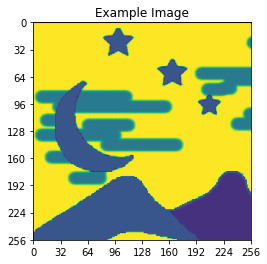

In [152]:
from PIL import Image

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('images/edge-detection.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Example Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [153]:
qc_class = QuantumFilters2D(shape=(2,2), stride=1)

qc_class.generate_unitaries(gates_name='G3',num_gates=50, num_filters=32, num_features = 1, save=True)

In [154]:
qc_class = QuantumFilters2D(shape=(2,2), stride=1)

qc_class.load_unitaries(name='U.pickle')

In [155]:
#Reshape data
data = torch.tensor(image.reshape(1,1,256,256))

start_time = time.time()
result = qc_class.get_quantum_filters(data, tol=1e-6)
finish_time = time.time() - start_time
print('Output shape = ', result.shape)
print('Execution time for a single channel:', finish_time)

Output shape =  torch.Size([1, 32, 256, 256])
Execution time for a single channel: 0.19735193252563477


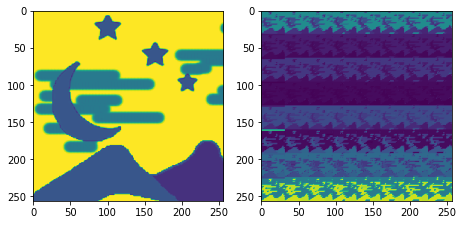

In [156]:
fig = plt.figure(figsize=(7.5,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
ax2.imshow(result[0,3], extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [157]:
qc_class = QuantumFilters2D(shape=(8,8), stride=1, backend='aer_simulator', shots=100)

qc_class.generate_qc(gates_name='G3',num_gates=50, num_filters=5, num_features = 1, save=True)

In [158]:
#Reshape data
data = torch.tensor(image.reshape(1,1,256,256))

start_time = time.time()
result = qc_class.get_quantum_filters(data.numpy(), tol=1e-6)
finish_time = time.time() - start_time
print('Output shape = ', result.shape)
print('Execution time for a single channel:', finish_time)

Output shape =  (1, 5, 256, 256, 256)
Execution time for a single channel: 219.2958014011383


In [159]:
from qiskit.providers.fake_provider import FakeMelbourne
fake = FakeMelbourne()
fake.status()

In [160]:
qc_class = QuantumFilters2D(shape=(8,8), shots=100, backend =fake, stride=1)

qc_class.load_gates()

In [161]:
#Reshape data
data = torch.tensor(image.reshape(1,1,256,256))

start_time = time.time()
result = qc_class.get_quantum_filters(data.numpy(), tol=1e-6)
finish_time = time.time() - start_time
print('Output shape = ', result.shape)
print('Execution time for a single channel:', finish_time)

Output shape =  (1, 5, 256, 256, 256)
Execution time for a single channel: 12102.97955918312
